In [1]:
### ARIMA Modeling

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [3]:
### Load data: Tororto Ferry Tickets 2022 onwards
from pathlib import Path

cur_dir = Path().cwd()
data_path = cur_dir.parent / "data" / "processed" / "daily_tickets_2022_25.parquet"

data = pd.read_parquet(data_path) 

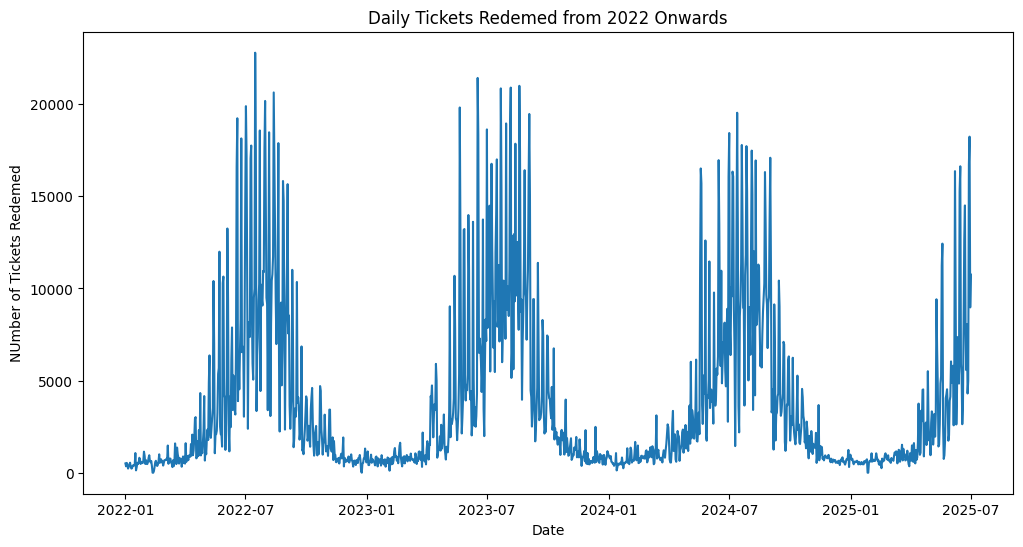

In [4]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=data, x="Timestamp", y="Redemption Count", ax=ax)
ax.set_title("Daily Tickets Redemed from 2022 Onwards")
ax.set_xlabel("Date")
ax.set_ylabel("NUmber of Tickets Redemed")
plt.show()



In [5]:
data["log_transformed_redem"] = np.log1p(data["Redemption Count"])
data["diff_log_redem"] = data["log_transformed_redem"].diff()
data = data.dropna().reset_index(drop=True)

display(data.head())


,Timestamp,Redemption Count,Sales Count,log_transformed_redem,diff_log_redem
0,2022-01-02,345,322,5.846439,-0.376137
1,2022-01-03,532,503,6.278521,0.432083
2,2022-01-04,475,412,6.165418,-0.113104
3,2022-01-05,225,201,5.420535,-0.744883
4,2022-01-06,358,324,5.883322,0.462787


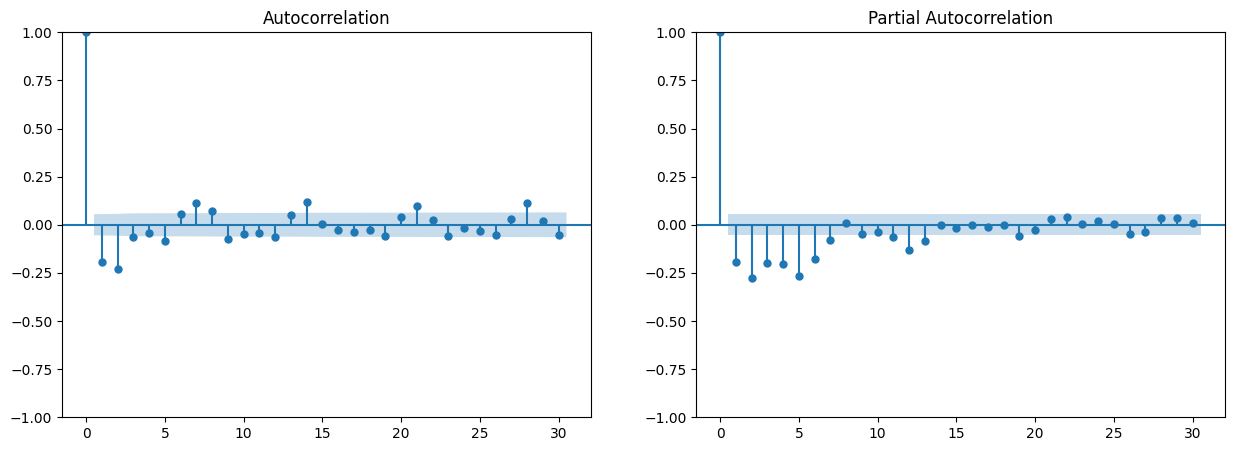

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data["diff_log_redem"], lags=30, ax=ax[0])
plot_pacf(data["diff_log_redem"], lags=30, ax=ax[1])
plt.show()
# Define ARIMA model parameters

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [8]:
df = data.copy()  # or your original dataframe
df = df[['Timestamp', 'log_transformed_redem']].dropna()
df = df.set_index('Timestamp')
y = df['log_transformed_redem']


In [9]:
def evaluate_sarima_with_tscv(y, order=(1,0,0), seasonal_order=(0,0,0,0), n_splits=5):
    """
    Perform TimeSeriesSplit CV for SARIMA model.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=7)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(y)):
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        result = model.fit(disp=False)

        preds = result.forecast(steps=len(y_test))
        
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(y_train.index[-50:], y_train[-50:], label='Train')
        ax.plot(y_test.index, y_test, label='Test', color='green') 
        ax.plot(preds.index, preds, label='Forecast', color='orange')
        ax.set_title(f'SARIMA Forecast - Fold {fold+1}')
        ax.legend()
        plt.show()

        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        fold_results.append({'fold': fold+1, 'MAE': mae, 'RMSE': rmse})

        print(f"Fold {fold+1}: MAE={mae:.4f}, RMSE={rmse:.4f}")

    results_df = pd.DataFrame(fold_results)
    print("\nAverage metrics:")
    print(results_df.mean(numeric_only=True))

    return results_df


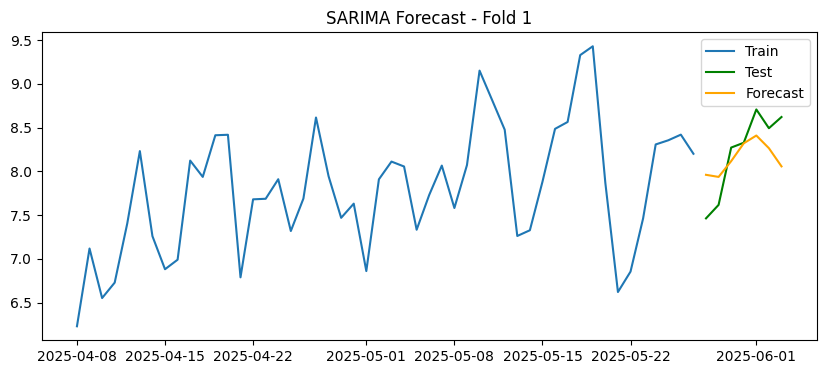

Fold 1: MAE=0.2957, RMSE=0.3451


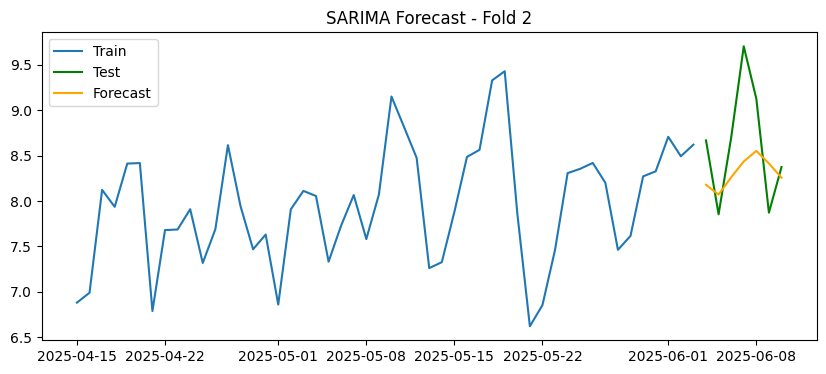

Fold 2: MAE=0.5204, RMSE=0.6236


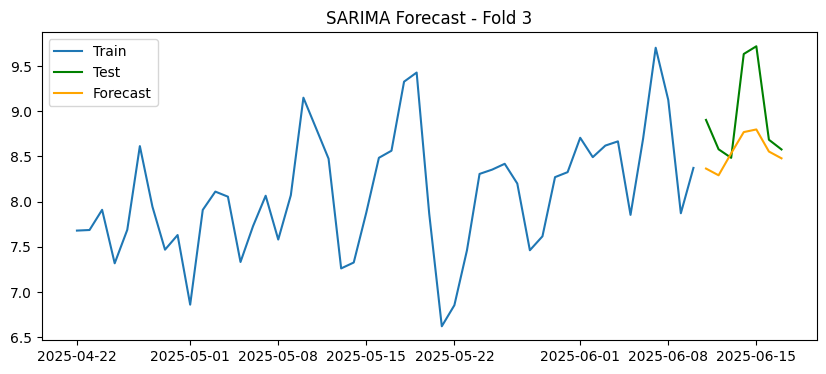

Fold 3: MAE=0.4129, RMSE=0.5341


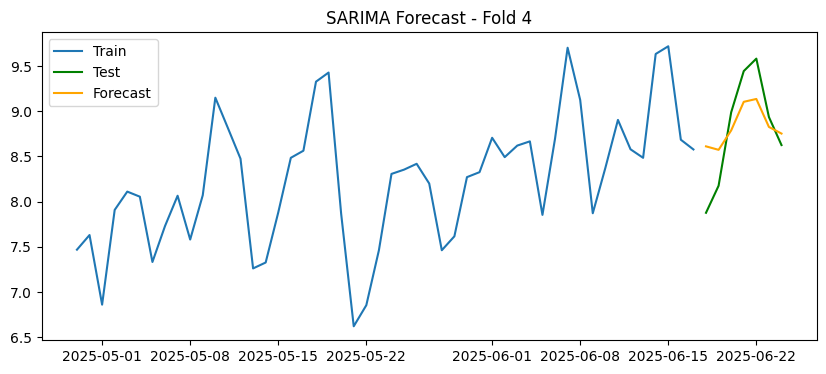

Fold 4: MAE=0.3367, RMSE=0.3931


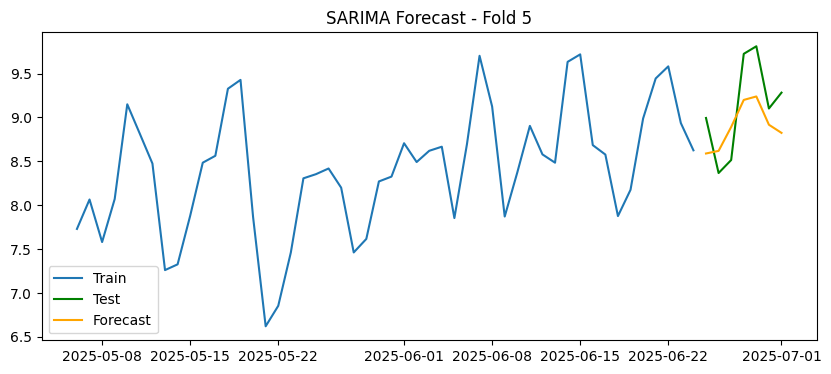

Fold 5: MAE=0.3964, RMSE=0.4170

Average metrics:
fold    3.000000
MAE     0.392415
RMSE    0.462572
dtype: float64


In [10]:
results = evaluate_sarima_with_tscv(
    y,
    order=(2,1,2),              # ARIMA(p,d,q)
    seasonal_order=(1,0,1,7),   # SARIMA(P,D,Q,s)
    n_splits=5
)


In [11]:
display(results)

,fold,MAE,RMSE
0,1,0.295710,0.345060
1,2,0.520443,0.623593
2,3,0.412877,0.534100
3,4,0.336684,0.393146
4,5,0.396363,0.416959


In [12]:
final_model = SARIMAX(
    y,
    order=(2,1,2),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_res = final_model.fit(disp=False)

forecast_steps = 30
future_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast = final_res.forecast(steps=forecast_steps)
forecast = pd.Series(forecast, index=future_index)

                                      SARIMAX Results                                      
Dep. Variable:               log_transformed_redem   No. Observations:                 1277
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -1129.525
Date:                             Wed, 29 Oct 2025   AIC                           2273.050
Time:                                     23:04:08   BIC                           2309.056
Sample:                                 01-02-2022   HQIC                          2286.578
                                      - 07-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3908      0.250      1.561      0.119      -0.100       0.882
ar.L2         -0.1108      

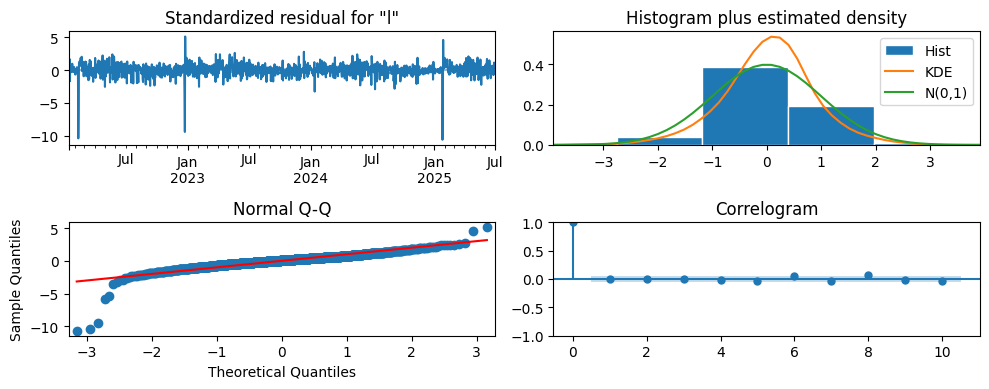

In [13]:
# Print model summary
print(final_res.summary())

# Plot residual diagnostics
final_res.plot_diagnostics(figsize=(10, 4))
plt.tight_layout()
plt.show()



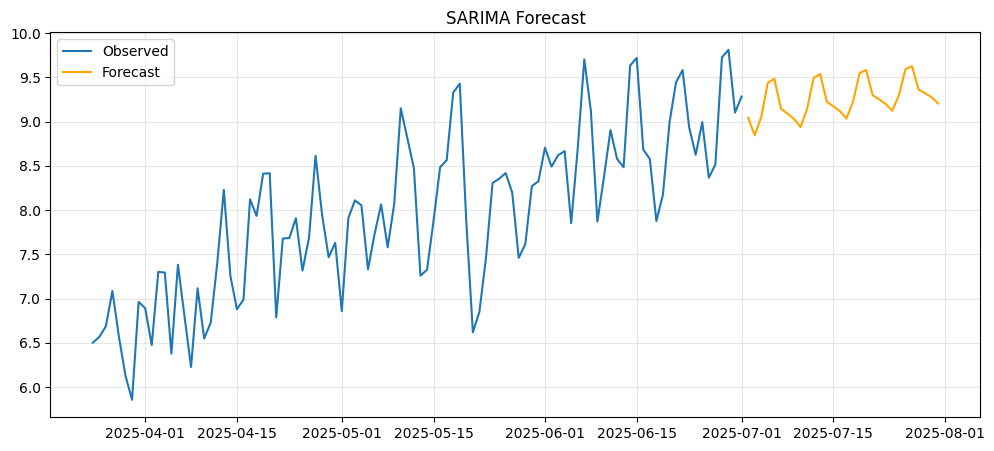

In [14]:
plt.figure(figsize=(12,5))
plt.plot(y[-100:], label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', color='orange')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [15]:
# import joblib
# model_path = cur_dir.parent / "models"
# model_path.mkdir(parents=True, exist_ok=True)
# joblib.dump(final_res, model_path / "sarima_model.pkl")



In [17]:
tracking_path = cur_dir.parent / "mlruns"
tracking_path = (cur_dir.parent / "mlruns").resolve()  # ensure absolute path
tracking_path.mkdir(exist_ok=True)

In [19]:
tracking_path_uri = tracking_path.as_uri()
tracking_path_uri


'file:///C:/Users/elias/Documents/MLOps/mlflow_prophet_lightgbm/mlruns'

In [20]:
import mlflow



mlflow.set_tracking_uri(tracking_path_uri)

mlflow.set_experiment("SARIMA_Toronto_Ferry_Tickets")

with mlflow.start_run(run_name="SARIMA_Modeling") as run:
    mlflow.log_param("order", (2,1,2))
    mlflow.log_param("seasonal_order", (1,0,1,7))
    avg_mae = results['MAE'].mean()
    avg_rmse = results['RMSE'].mean()
    mlflow.log_metric("avg_MAE", avg_mae)
    mlflow.log_metric("avg_RMSE", avg_rmse)
    mlflow.log_metric("AIC", final_res.aic)
    mlflow.log_metric("BIC", final_res.bic)
    mlflow.log_metric("HQIC", final_res.hqic)

    
    mlflow.statsmodels.log_model(final_res, artifact_path="sarima_model")
    print(f"Logged SARIMA model with run_id: {run.info.run_id}")
    

2025/10/29 23:30:12 INFO mlflow.tracking.fluent: Experiment with name 'SARIMA_Toronto_Ferry_Tickets' does not exist. Creating a new experiment.
2025/10/29 23:30:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Logged SARIMA model with run_id: 483494323e33468eadfc7ded95bc9292
